# **Case Study: Yelp Restaurant Recommendation System**

---------------
## **Context**
---------------

**Yelp** was founded in **2004** to help people find **great local businesses**. Today, the website and their mobile application publish crowd-sourced reviews about local businesses as well as certain metadata about them that can help in customer's **decision-making process**. Yelp uses automated software to recommend the **most helpful** and **reliable reviews** for the Yelp community from such a large and diverse dataset.

The Yelp dataset is a large collection of user reviews, business metadata, business check-ins, users' social network data, user tips for businesses across 10 cities spread across **4 countries**. The original dataset is very huge with ~ 11GB of data. In this case study, we will only use a subset of data due to hardware limitations.

-----------------
## **Objective**
-----------------

In this case study, we will build three types of recommendation systems: 
- **Clustering-based recommendation system**
- **Content-based collaborative filtering**

-----------------
## **Dataset**
-----------------

We will only use the following four attributes from the **yelp_reviews dataset**: 
- business_id
- business_name
- stars
- user_id
- text: The text review by the user

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
# Mount the drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install the surprise package using the following line of code

!pip install surprise

     |████████████████████████████████| 11.8 MB 5.3 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630144 sha256=d66aa83cbb59185202384d9c8c112d9a4270a4a0ece45559cba4b3c15967ef98
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [ ]:
# Importing necessary libraries

import warnings                                               # Used to ignore the warnings in the error message
warnings.filterwarnings('ignore')

import numpy as np                                            # A basic python package for numerical operations
import pandas as pd                                           # A python library to process and do computations on the data frames

import matplotlib.pyplot as plt                               # A basic library to do data visualizations
import seaborn as sns                                         # A slightly advanced one for data visualization
from collections import defaultdict                           # A dictionary output that does not raise a key error
from sklearn.metrics.pairwise import cosine_similarity        # To compute the cosine similarity between vectors
from sklearn.preprocessing import LabelEncoder                # To do label encoding

### **Loading the data**

In [ ]:
# Import the dataset
reviews = pd.read_csv('/content/drive/MyDrive/ADSP/yelp/yelp_reviews.csv', usecols = ['user_id', 'business_id', 'business_name', 'stars', 'text'])

# See the first 5 records of the dataset
reviews.head()

,business_id,business_name,stars,text,user_id
0,9yKzy9PApeiPPOUJEtnvkg,Morning Glory Cafe,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q
1,ZRJwVLyzEJq1VAihDhYiow,Spinato's Pizzeria,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ
2,6oRAC4uyJCsJl1X0WZpVSA,Haji-Baba,4,love the gyro plate. Rice is so good and I als...,0hT2KtfLiobPvh6cDC8JQg
3,_1QQZuf4zZOyFCvXc0o6Vg,Chaparral Dog Park,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg
4,6ozycU1RpktNG2-1BroVtw,Discount Tire,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw


In [ ]:
# Check the info of the data
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229907 entries, 0 to 229906
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   business_id    229907 non-null  object
 1   business_name  229907 non-null  object
 2   stars          229907 non-null  int64 
 3   text           229901 non-null  object
 4   user_id        229907 non-null  object
dtypes: int64(1), object(4)
memory usage: 8.8+ MB


- There are **2,29,907 observations and 5 columns** in the data.
- There are **no missing values** in the data.
- All the **columns are of object data type except the stars column** which is of numeric data type.

## **Data Exploration**

Let's start with the data exploration.

**Print the top 5 rows of the dataset and describe the dataset.**  

In [ ]:
# Printing the first 5 rows of the dataset
reviews.head()

,business_id,business_name,stars,text,user_id
0,9yKzy9PApeiPPOUJEtnvkg,Morning Glory Cafe,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q
1,ZRJwVLyzEJq1VAihDhYiow,Spinato's Pizzeria,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ
2,6oRAC4uyJCsJl1X0WZpVSA,Haji-Baba,4,love the gyro plate. Rice is so good and I als...,0hT2KtfLiobPvh6cDC8JQg
3,_1QQZuf4zZOyFCvXc0o6Vg,Chaparral Dog Park,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg
4,6ozycU1RpktNG2-1BroVtw,Discount Tire,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw


#### **Describe the distribution of ratings**

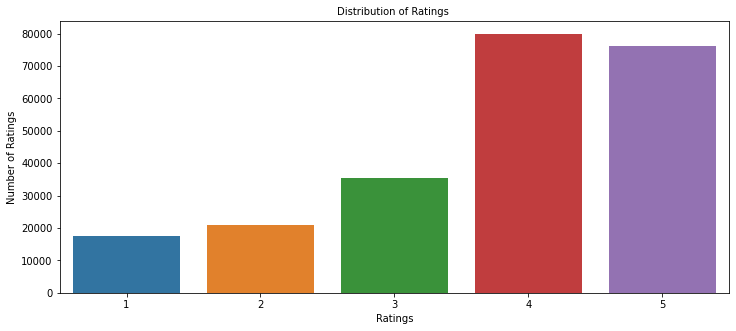

In [ ]:
# Fix the figure size of the plot
plt.figure(figsize = (12, 5))

# Code to create the countplot
ax = sns.countplot(x="stars", data = reviews)

plt.tick_params(labelsize = 10)

plt.title("Distribution of Ratings ", fontsize = 10)

plt.xlabel("Ratings", fontsize = 10)

plt.ylabel("Number of Ratings", fontsize = 10)

# Show the plot
plt.show()

**Observations:**

* Data seems to be **highly skewed** towards Rating **'4' and '5'**. Rating **'5'** is the second-highest in the count and nearly the same as the number of 4 rating count. 

* We can see very few people are giving ratings **between 1 to 3**. It shows people tend to **not give a rating** for a restaurant that they **dislike**.

#### **What is the total number of unique users and unique Restaurants?**

In [ ]:
# Number of unique users
reviews['user_id'].nunique()

45981

In [ ]:
# Number of unique Restaurant 
reviews['business_id'].nunique()

11537

**Observations:**
- There are **45981 users** in the dataset
- There are **11537 Restaurants** in the dataset
- As per the number of unique users and Restaurant, there is a **possibility of 45981 * 11537 = ~ 53 x 10^7 ratings** in the dataset. But **we have 229907 ratings**, i.e., not every user has rated every Restaurant in the dataset. And we can build a recommendation system to recommend a restaurant to users which they have not interacted with.

#### **Is there any restaurant that has been visited more than once by the same user?**

In [ ]:
reviews.groupby(['user_id', 'business_id']).count()

business_name  stars  text
user_id                business_id                                       
--5hzxWLz5ozIg6OMo6tpQ Z3n01OZqARDv06QgBneOZw              1      1     1
--65q1FpAL_UQtVZ2PTGew -q_VodbABJygOSuv86LOtw              1      1     1
                       -sC66z4SO3tR7nFCjfQwuQ              1      1     1
                       0vzZ_Bcb02rJljeMU9XkBw              1      1     1
                       18TUn9oiW0k0yB6lheiOvw              1      1     1
...                                                      ...    ...   ...
zztT9KKp0rmJRMeMl4CqzQ A8Khz3eeqIFFGaXurg3hxw              1      1     1
                       ilJiRYZgxjrEu2iexKu-pQ              1      1     1
                       sbsFamEj5wDxNAjUKrMcSw              1      1     1
                       wP5849J1DKB2KS3M6UwOAg              1      1     1
zzunUJtZqhcxDB3plnSFxg kuGQG_8i9P-4p9_Mym-G8Q              1      1     1

[229906 rows x 3 columns]

In [ ]:
reviews.groupby(['user_id', 'business_id']).count()['stars'].sum()

229907

- The **sum is equal to the total number of observations** which implies that **there is only interaction between a pair of user and a restaurant**.

#### **Which Restaurant is the most reviewed Restaurant in the dataset?**

In [ ]:
reviews['business_id'].value_counts()

hW0Ne_HTHEAgGF1rAdmR-g    844
VVeogjZya58oiTxK7qUjAQ    794
JokKtdXU7zXHcr20Lrk29A    731
ntN85eu27C04nwyPa8IHtw    679
EWMwV5V9BxNs_U6nNVMeqw    645
                         ... 
-NbEHP2GHFNb5PnmJnd4qQ      3
QICgwHWhXIbihfcMKtws8g      3
sAwxt4I4gTiL-08nyarJbg      3
huzUWI5YqkJEEIudo0YiDg      3
SeCVec3f91bEdosAILE4JA      3
Name: business_id, Length: 11537, dtype: int64

**Observations:**
- The **Restaurant with business_id: hW0Ne_HTHEAgGF1rAdmR-g  has been interacted by most users** which is **844** times.
- But still, there is a possibility of **45981 - 844 = 45137** more interactions as we have **45981** unique users in our datasets. For those  **remaining users**, we can build a **recommendation system** to predict who is most likely to visit the Restaurant.

Also, out of these **844 interactions**, we need to consider the distribution of ratings as well to check whether this Restaurant is the **most liked or most disliked Restaurant**.

#### **Which user interacted the most with any Restaurant in the dataset?**

In [ ]:
reviews['user_id'].value_counts()

fczQCSmaWF78toLEmb0Zsw    588
90a6z--_CUrl84aCzZyPsg    506
0CMz8YaO3f8xu4KqQgKb9Q    473
4ozupHULqGyO42s3zNUzOQ    442
joIzw_aUiNvBTuGoytrH7g    392
                         ... 
Oh9OOyDSGf4eNWGiNazh8g      1
Np9IEqnLmhRB2T5jumPTGw      1
g0-ejhzvo0ELNp04cUKWDg      1
M0lyA1jF0zrXZr5TXlioTQ      1
dDNfSFT0VApxPmURclX6_g      1
Name: user_id, Length: 45981, dtype: int64

**Observations:**
- The user with **user_id: fczQCSmaWF78toLEmb0Zsw** have interacted with the most number of restaurants, i.e., **588** times. 
- But still, there is a possibility of **11537 - 588 =  10949** more interactions as we have **11537 unique Restaurants** in our dataset. For those **10949** remaining Restaurants, we can build a recommendation system to predict which restaurants are most likely to be reviewed by this user.

**As this dataset is very large and has 229907 observations, it is not computationally possible to build a model using this. Moreover, there are many users who have only rated a few restaurants and also there are restaurants which are rated by very less users. Hence we can reduce the dataset by considering certain Logical assumption.**

Here, We will be taking users who have given at least 100 rating, as we prefer to have some number of rating of a restaurant.

In [ ]:
# Get the column containing the users
users = reviews.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1   

In [ ]:
# We want our users to have at least 100 ratings to be considred
RATINGS_CUTOFF = 100

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
reviews = reviews.loc[ ~ reviews.user_id.isin(remove_users)]

The columns **business_id** and **user_id** are encrypted to provide anonymity. To ease our processing of the dataset we will use **label encodings** to process these two variables.

In [ ]:
# Label Encoding
le = LabelEncoder()

# Fit transform the user_id column
reviews['user_id'] = le.fit_transform(reviews['user_id'])

# Fit transform the business_id column
reviews['business_id'] = le.fit_transform(reviews['business_id'])

In [ ]:
# See the first 5 records
reviews.head()

,business_id,business_name,stars,text,user_id
0,1348,Morning Glory Cafe,5,My wife took me here on my birthday for breakf...,188
6,7479,La Condesa Gourmet Taco Shop,5,Drop what you're doing and drive here. After I...,203
13,3975,The Lady Luck Tattoo Gallery,4,"Good tattoo shop. Clean space, multiple artist...",112
18,4620,Carlsbad Tavern,3,I met a friend for lunch yesterday. \n\nLoved ...,102
19,654,Frontier Airlines,4,They've gotten better and better for me in the...,172


In [ ]:
# Calculating average ratings
average_rating = reviews.groupby('business_id').mean()['stars']

# Calculating the count of ratings
count_rating = reviews.groupby('business_id').count()['stars']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

To demonstrate the **clustering-based recommendation system** the **Surprise package** is introduced in this case study.
- Please use the following code to install the surprise library. You only do it once while running the code for the first time.

**!pip install surprise**

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# This class is used to parse a file containing ratings, data should be in structure - user; item; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing clustering based recommendation system
from surprise import CoClustering

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k and recall@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Returns precision and recall at k metrics for each user."""

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant. When n_rec_k is 0, 
        # Precision is undefined. We here set Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended. When n_rel is 0, 
        # Recall is undefined. We here set Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)

    # Command to print the overall precision
    print('Precision: ', precision)

    # Command to print the overall recall
    print('Recall: ', recall)

    # Formula to compute the F-1 score
    print('F_1 score: ', round((2*precision * recall) / (precision + recall), 3))

Below we are loading the **`rating` dataset**, which is a **pandas dataframe**, into a **different format called `surprise.dataset.DatasetAutoFolds`** which is required by this library. To do this we will be **using the classes `Reader` and `Dataset`**.

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the dataset
data = Dataset.load_from_df(reviews[['user_id', 'business_id', 'stars']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

## **Cluster-Based Recommendation System**

In **clustering-based recommendation systems**, we explore the **similarities and differences** in people's tastes in restaurants based on how they rate different restaurants. We cluster similar users together and recommend restaurants to a user based on ratings from other users in the same cluster.

- **Co-clustering** is a set of techniques in **Cluster Analysis**. Given some **matrix A, we want to cluster rows of A and columns of A simultaneously**, this is a common task for user-item matrices. 

- As it clusters both the rows and columns simultaneously, it is also called **bi-clustering**. To understand the working of the algorithm let A be m x n matrix, goal is to generate co-clusters: a subset of rows that exhibit similar behavior across a subset of columns, or vice versa.

- Co-clustering is defined as two map functions:
rows -> row cluster indexes
columns -> column cluster indexes
These map functions are learned simultaneously. It is **different from other clustering techniques** where we cluster **first the rows and then the columns**. 

In [ ]:
# Using Co-Clustering algorithm
clust_baseline = CoClustering(random_state = 1)

# Training the algorithm on the trainset
clust_baseline.fit(trainset)

# Let us compute precision@k and recall@k with k = 10
precision_recall_at_k(clust_baseline)

RMSE: 1.0378
Precision:  0.765
Recall:  0.403
F_1 score:  0.528




* We have calculated **RMSE** to check **how far the overall predicted ratings** are from the **actual ratings**.

* Here **F_1 score** of the **baseline model is almost 0.528**. It indicates that **recommended restaurants were relevant and relevant restaurants were recommended for more than half the recommendations**. We will try to improve this later by using **GridSearchCV by tuning different hyperparameters** of this algorithm.

Let's now predict a rating for a user with `userId = 4` and `business_Id = 9483` as shown below.

In [ ]:
# Making prediction for user_id 4 and business_id 9483
clust_baseline.predict(4, 9483, r_ui = 5, verbose = True)

user: 4          item: 9483       r_ui = 5.00   est = 3.70   {'was_impossible': False}


Prediction(uid=4, iid=9483, r_ui=5, est=3.7043858116372532, details={'was_impossible': False})

As we can see - the **actual rating** for this **user-item pair is 5** and the **predicted rating is 3.70 by this Co-clustering based baseline model**. It seems like the model has under-estimated the rating. We will try to fix this later by tuning the hyperparameters of the model using GridSearchCV.

Below we are predicting rating for the same `userId = 4` but for a restaurant which this user has not visited before, i.e., `business_id = 9980`, as shown below.

In [ ]:
# Making prediction for userid 4 and business_id 9980
clust_baseline.predict(4, 9980, verbose = True)

user: 4          item: 9980       r_ui = None   est = 3.70   {'was_impossible': False}


Prediction(uid=4, iid=9980, r_ui=None, est=3.7043858116372532, details={'was_impossible': False})

We can see that **estimated rating** for this user-item pair is 3.70 based on this Co-clustering based baseline model.

### **Improving clustering based recommendation system by tuning its hyper-parameters**

Below we will be tuning hyper-parameters for the `CoClustering` algorithms. Let's try to understand different hyperparameters of this algorithm.

- **n_cltr_u** (int) – Number of **user clusters**. The default value is 3.
- **n_cltr_i** (int) – Number of **item clusters**. The default value is 3.
- **n_epochs** (int) – Number of **iteration of the optimization loop**. The default value is 20.
- **random_state** (int, RandomState instance from NumPy, or None) – Determines the RNG that will be used for initialization. If int, random_state will be used as a seed for a new RNG. This is useful to get the same initialization over multiple calls to fit(). If RandomState instance, this same instance is used as RNG. If None, the current RNG from numpy is used. The default value is None.
- **verbose** (bool) – If True, the current epoch will be printed. The default value is False.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_cltr_u': [3, 4, 5, 6], 'n_cltr_i': [3, 4, 5, 6], 'n_epochs': [30, 40, 50]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(CoClustering, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0397794294632192
{'n_cltr_u': 3, 'n_cltr_i': 3, 'n_epochs': 50}


Once the grid search is **complete**, we can get the **optimal values** for each of those hyper-parameters as shown above.

Now we will build **final model** by using tuned values of the hyperparameters which we received by using grid search cross-validation.

In [ ]:
# Using tuned Coclustering algorithm
clust_tuned = CoClustering(n_cltr_u = 3,n_cltr_i = 3, n_epochs = 40, random_state = 1)

# Training the algorithm on the trainset
clust_tuned.fit(trainset)

# Let us compute precision@k and recall@k with k = 10
precision_recall_at_k(clust_tuned)

RMSE: 1.0373
Precision:  0.764
Recall:  0.404
F_1 score:  0.529


- We can see that the **F_1 score** for **tuned co-clustering model** on testset is **comparable with F_1 score** for baseline Co-clustering model. The model performance has not improved by much.

Let's now **predict rating** for a user with `userId = 4` and for `business_id = 9483` as shown below.Here the user has already rated the restaurant.

In [ ]:
# Using co_clustering_optimized model to recommend for userId 4 and business_id 9483
clust_tuned.predict(4, 9483, r_ui = 5, verbose = True)

user: 4          item: 9483       r_ui = 5.00   est = 3.70   {'was_impossible': False}


Prediction(uid=4, iid=9483, r_ui=5, est=3.7043858116372532, details={'was_impossible': False})

Below we are predicting rating for the same `userId = 4` but for a restaurant which this user has not visited before, i.e., `business_id = 9980`, as shown below.

In [ ]:
# Using Co_clustering based optimized model to recommend for userId 4 and business_id 9980 with unknown baseline rating
clust_tuned.predict(4, 9980, verbose = True)

user: 4          item: 9980       r_ui = None   est = 3.70   {'was_impossible': False}


Prediction(uid=4, iid=9980, r_ui=None, est=3.7043858116372532, details={'was_impossible': False})

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

The input parameters of the below function are as follows.

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of restaurants we want to recommend**
- algo: The algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended restaurants ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot_table(index = 'user_id', columns = 'business_id', values = 'stars')
    
    # Extracting those restaurants ids which the user_id has not interacted yet
    non_interacted_restaurants = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the restaurants ids which user_id has not interacted yet
    for item_id in non_interacted_restaurants:
        
        # Predicting the ratings for those non interacted restaurants ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    # Returing top n highest predicted rating restaurants for this user
    return recommendations[:top_n]

In [ ]:
# Getting top 5 recommendations for user_id 4 using "Co-clustering based optimized" algorithm
clustering_recommendations = get_recommendations(reviews, 4, 5, clust_tuned)

### **Correcting the Ratings and Ranking the above restaurants

While comparing the ratings of two products, it is not only the **ratings** that describe the **likelihood of the user to that product**. Along with the rating the **number of users who have seen that product** also becomes important to consider. Due to this, we have calculated the **"corrected_ratings"** for each product. Commonly higher the **"rating_count" of a product more it is liked by users**. To interpret the above concept, a **product rated 4 with rating_count 3 is less liked in comparison to a product rated 3 with a rating count of 50**. It has been **empirically found that the likelihood of the product is directly proportional to the inverse of the square root of the rating_count of the product**.

In [ ]:
def ranking_restaurants(recommendations, final_rating):
  
  # Sort the restaurants based on ratings count
  ranked_restaurants = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending = False)[['rating_count']].reset_index()

  # Merge with the recommended restaurants to get predicted ratings
  ranked_restaurants = ranked_restaurants.merge(pd.DataFrame(recommendations, columns = ['business_id', 'predicted_ratings']), on = 'business_id', how = 'inner')

  # Rank the restaurants based on corrected ratings
  ranked_restaurants['corrected_ratings'] = ranked_restaurants['predicted_ratings'] - 1 / np.sqrt(ranked_restaurants['rating_count'])

  # Sort the restaurants based on corrected ratings
  ranked_restaurants = ranked_restaurants.sort_values('corrected_ratings', ascending = False)
  
  return ranked_restaurants

**Note:** In the **above-corrected rating formula**, we can add the **quantity `1 / np.sqrt(n)` instead of subtracting it to get more optimistic predictions**. But here we are **subtracting this quantity**, as there are some restaurants with ratings 5 and **we can't have a rating more than 5 for a restaurant**.

In [ ]:
# Ranking restaurants based on above recommendations
ranking_restaurants(clustering_recommendations, final_rating)

,business_id,rating_count,predicted_ratings,corrected_ratings
0,56,2,5,4.292893
1,26,1,5,4.000000
2,29,1,5,4.000000
3,40,1,5,4.000000
4,43,1,5,4.000000


**Let us now move to the final recommendation algorithm which is named the Content-based recommendation system.**

## **Content-based recommendation system**

In a content-based recommendation system, we would be using the feature - **text**, i.e., reviews to find out similar businesses.

Text data generally contains pronunciation, stopwords, non-ASCII characters which makes it **very noisy**. So, we will first need to **pre-process the text** and then we will **generate features from the text to compute similarities** between the texts/reviews. Before that, let's see some terminology:

**stopwords:** A stop word is a commonly used word (such as “the”, “a”, “an”, or “in”) that does not contain information in the text and can be ignored.
**Lemmatization:** Lemmatization in linguistics is the process of grouping together the inflected forms of a word so they can be analyzed as a single item. For example, runs, running, and ran are all forms of the word run, therefore run is the lemma of all these words.

In [ ]:
# Importing regular expression
import re

# Importing word tokenize
from nltk import word_tokenize

# Importing word WordNetLemmatizer
from nltk.stem import WordNetLemmatizer

# Importing word stopwords
from nltk.corpus import stopwords

# Importing word TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def tokenize(text):
    
    # Making each letter as lowercase and removing non-alphabetical text
    text = re.sub(r"[^a-zA-Z]", " ", text.lower())
    
    # Extracting each word in the text
    tokens = word_tokenize(text)
    
    # Removing stopwords
    words = [word for word in tokens if word not in stopwords.words("english")]
    
    # Lemmatize the words
    text_lems = [WordNetLemmatizer().lemmatize(lem).strip() for lem in words]

    return text_lems

### **Feature Extraction**

Below are some of the ways to extract features from texts.
- Bag of words
- TF-IDF
- One hot encoding
- Word vectors

Here, we will be using **tfidf** as a feature extraction technique.

In [ ]:
# Selecting a random subset of the original data
reviews_small = reviews.sample(n = 1000, random_state = 42)

# Setting the index
reviews_small = reviews_small.set_index('business_name')

# Creating the indices object
indices = pd.Series(reviews_small.index)

# Let us see the first 5 indices
indices[:5]

0               Johnny's Uptown
1    Golden Spoon Frozen Yogurt
2      Coco's Family Restaurant
3                     Food City
4                  Julioberto's
Name: business_name, dtype: object

In [ ]:
# Import nltk
import nltk

# Downlaod the punkt for punctuation
nltk.download("punkt")

# Downlaod the stopwords
nltk.download('stopwords')

# Download the wordnet
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# Create the TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer = tokenize)

review_tfidf = tfidf.fit_transform(reviews_small['text'].values).toarray()

In [ ]:
# Let us view the review_tfidf dataframe
pd.DataFrame(review_tfidf)

,0,1,2,3,4,5,6,7,8,9,...,9719,9720,9721,9722,9723,9724,9725,9726,9727,9728
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.136909,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


We have extracted **9729 features** from the text data. Now, we can find similarities between businesses using these features. We will use cosine similarity to calculate the similarity.

In [ ]:
similar_review = cosine_similarity(review_tfidf, review_tfidf)
similar_review

array([[1.        , 0.0153254 , 0.050605  , ..., 0.02126092, 0.02458539,
        0.04139967],
       [0.0153254 , 1.        , 0.05231965, ..., 0.00561574, 0.        ,
        0.03093412],
       [0.050605  , 0.05231965, 1.        , ..., 0.00881088, 0.03442084,
        0.05101726],
       ...,
       [0.02126092, 0.00561574, 0.00881088, ..., 1.        , 0.16178544,
        0.01478691],
       [0.02458539, 0.        , 0.03442084, ..., 0.16178544, 1.        ,
        0.        ],
       [0.04139967, 0.03093412, 0.05101726, ..., 0.01478691, 0.        ,
        1.        ]])

**Finally, let's create a function to find most similar businesses to recommend for a given business.**

In [ ]:
# Function that takes in business title as input and returns the top 10 recommended businesses
def recommendations(title, similar_review):
    
    recommended_businesses = []
    
    indices = pd.Series(reviews_small.index)
    
    # Getting the index of the business that matches the title
    idx = indices[indices == title].index[0]

    # Creating a Series with the similarity scores in descending order
    score_series = pd.Series(similar_review[idx]).sort_values(ascending = False)

    # Getting the indices of 10 most similar businesses
    top_10_indexes = list(score_series.iloc[1 : 11].index)
    
    # Let us print the top_10_indexes
    print(top_10_indexes)
    
    # populating the list with the titles of the best 10 matching businesses
    for i in top_10_indexes:
        recommended_businesses.append(list(reviews_small.index)[i])
        
    return recommended_businesses

In [ ]:
# Implement the recommendations function
recommendations("Johnny's Uptown", similar_review)

[665, 675, 761, 269, 971, 777, 861, 634, 824, 811]


['St Francis Restaurant',
 '98 South',
 'RA Sushi Bar Restaurant',
 'Bliss ReBAR',
 "Grimaldi's Pizzeria",
 'The Clubhouse Music Venue',
 "Joe's Farm Grill",
 'Java Magazine',
 'Orange Table',
 'Best Hong Kong Dining']

- The **Asian Cafe Express** is a top-rated restaurant in the subset reviews_small and the majority of our recommendations are restaurants with 4 or 5 stars which implies that the resulting recommendation system is working well.

### **Conclusion**

In this notebook, we have seen below recommendation techniques: 
- **Clustering based recommendation systems**
- **Content based recommendation systems**

We have see how they are different from each other and what kind of data is needed to build each of these two recommendation systems. We can further combine all the recommendation techniques we have see so far to create a hybrid recommendation system.